# Introduction and Motivation

As both an aspiring guitarist and product management/data science professional, I thought it would be a great idea to merge my interests into one project - using data to explore basic guitar music theory and to inform my next steps for learning guitar.

#### Guitar Motivation
For the last year I have been self teaching myself guitar. Like all things I've self-taught in the past, I have spent endless hours on youtube, learning new songs, chords, etc. I feel like I've got the basics down now and can learn most songs after watching a youtube video or finding the chords online. However, I'm hungry now to get into that next level of understanding - music theory. I want to know what and why I'm playing. I've found myself asking questions like - What chords sound good together? Why does chord x always show up after chord y? How can I think about starting to write my own music? What song should I be learning next? I've started diving into these questions through youtube, but like anything, I believed data could help guide my learning and decision making.

#### Data Motivation
Over the last few years, I've really found my interests converging at the intersetion of product and data. In school I was lucky enough to get involved in classes all over the data science spectrum, touching subjects and projects varying from ML to Data Visualization Interaction. Now as a Product manager, I am actively involved in analyzing our business data to help us make decisions on how to build our products!

Although I've done a lot so far, there's still so many more skills that I want to build upon in this space. For example, I've often worked with dirty data, usually in the form of logs generated from our software at work. However, I've never really had to gather it myself. And although I've gotten to answer some really cool questions with data, I've never been able to use data to explore a subject I really know nothing about.

#### Project  Overview

So for this project, I will be working down the data science pipeline from A-Z to explore the basics of music theory while simultaneosly building out my data science skills!

This notebook contains a majority of my work, broken up by each step in the process

1. Data Collection

2. Data Cleaning

3. Exploratory Data Analysis

4. Modeling

5. Conclusion/Takeaways


## 1. Data Collection

The first step of the process was finding or creating an approptiate data set of guitar chords/tabelature. Specifically, I wanted a large data set of guitar tabelature from a variety of different difficulty levels, genres, artists, etc. One of my main objectives for this project was to build out my own ETL pipeline. With that in mind I decided to build a web scraper. 

I scraped my data from the popular guitar tabelature website ultimate-guitar.com. To scrape the site I utilized the selenium data package. This was my first time web scraping so I relied heavily on this amazing [youtube tutorial](https://www.youtube.com/watch?v=Xjv1sY630Uc) from Tech With Tim ! The code for my scraper can be found in the scraping folder in my git. But I will give a brief overview of my process here...


#### Choosing a site to scrape

There are a few different websites that host guitar tabs, but the most popular by far is ultimate-guitar.com. I considered some other sites as well, but UG seemed to have by far the most inventory of tabs. More importantly, each tab seems to follow a similar format - which is great for scraping capabilities. 

Unfortunately, UG does not have a single location that lists all of it's tabs, so I had to get a bit creative. I decided to break the scraping up into two parts. First, using the search page on UG to find the links to different song tabs, and stored that data in a csv. Second, I used that list I generated of song tabs and scraped through each song one by one, and stored that data in a csv.

#### Gathering a list of tabs to scrape

To gather the list of song url's, I played around with the url of the explore page. I itiratevely changed the url to filter by different genres and decades, resulting in different results in the search page. For each decade/genre combination, I would use selenium to grab all the urls from that page, navigate to the next page (often there were about 20 pages of results), then grabbed those urls as well. I would then change the decade/genre filter and go again.

#### Scraping tabs

Scraping the actual tabs once I had the URLs for them was rather straightforward. From each page, I gathered all information available about the song (chords, difficulty, capo, etc).

#### Results and Takeaways

In the end, I finished with a dataset of a little under 10,000 unique song tabs for guitar. I actually had a list of 30k tabs to eventually scrape, but unfortunately UG kicked me off the site for generating too much traffic. I had no idea this was a thing, but after reading about similar incidents online I decided to shut down the remaining scraping. I am a big user of UG and don't want to break any of their rules further! This was a great lesson though for future scraping activities - make sure to understand the site's guidelines regarding scraping before moving forward!


## 2. Data Cleaning

My data set was quite expansive, but it was rather dirty. Before getting into any analysis I needed to do some basic cleaning. There is more cleaning to come throughout the analysis as I identified more errors, so this section is focused more instead on cleaning up the low hanging fruit.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import numpy as np
import math
import glob
import seaborn as sns

#### Read in and combine data files

I iteratively stored songs into different CSVs during scraping to avoid losing data if my computer shut down. So  we'll want to read all these files and combine them into one

In [48]:
# Combine csvs
all_files=glob.glob("/Users/eshantarneja/Documents/DataScience/data/rawData/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, encoding='latin-1')
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)
df.head()

,url,new_x,new_y,chordOrder,chordList,topInfo,songArtist
0,https://tabs.ultimate-guitar.com/tab/dolly-par...,['Country'],[1970],"['G', 'C', 'G', 'C', 'D', 'G', 'C', 'G', 'C', ...","['G', 'C', 'D']",[],Its All Wrong But Its All Right chords by Doll...
1,https://tabs.ultimate-guitar.com/tab/dolly-par...,"['Country', 'Folk', 'Folk']","[1970, 1970, 1940]","['Am', 'C', 'G', 'Am', 'G', 'Am', 'Am', 'C', '...","['Am', 'C', 'G']","['Difficulty: intermediate', 'Tuning: E A D G ...",Jolene chords by Dolly Parton
2,https://tabs.ultimate-guitar.com/tab/dolly-par...,['Country'],[1970],"['Em', 'G', 'D', 'Em', 'D', 'Em', 'Em', 'G', '...","['Em', 'G', 'D']","['Difficulty: novice', 'Tuning: E A D G B E', ...",Jolene chords by Dolly Parton
3,https://tabs.ultimate-guitar.com/tab/dolly-par...,"['Country', 'Folk']","[1970, 1970]","['Dm', 'F', 'C', 'Dm', 'C', 'Dm', 'F', 'C', 'D...","['Dm', 'F', 'C']",[],Jolene chords by Dolly Parton
4,https://tabs.ultimate-guitar.com/tab/dolly-par...,"['Country', 'Country', 'Folk', 'Folk']","[1970, 1940, 1970, 1940]","['Am', 'Am', 'C', 'G', 'Am', 'G', 'Am', 'Am', ...","['Am', 'C', 'G', 'Em']","['Difficulty: novice', 'Tuning: E A D G B E', ...",Jolene chords by Dolly Parton


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 7 columns):
url           9997 non-null object
new_x         9997 non-null object
new_y         9997 non-null object
chordOrder    9997 non-null object
chordList     9997 non-null object
topInfo       9997 non-null object
songArtist    9997 non-null object
dtypes: object(7)
memory usage: 546.8+ KB


#### Low Hanging Fruit

There are a couple of issues within this raw data that I can see just by looking at it. Lets clean those up to start.

1. Song and Artist are in a field together (i.e Dust Bowl chords by 10,000 Maniacs). We'll want to seperate these into their own fields

2. All of the lists got read in as strings. I can see that by all of them being read as "objects". I learned that reading and writing in csvs loses python formatting (this is what pckl files are great for apparently...I had always heard of these...never knew why people used them). I'll go ahead and convert those back into lists though.

3. The topInfo column has really disparate information about the song. This data is found at the top of the chord page and usually contains Key, Capo, and Tuning...but sometimes has only some of that info, and also sometimes has random facts about the song. I'll break these into their own fields if they exist, and if there is extra info, I'll put it in a column called "other"

4. I know from my original file combining that there are quite a few duplicates in the data. I.e these Urls were found in multiple genres and decades, but have the exact same tab (shown by url). That is why the genre and decades are stored as list because I combined all the info from each of these into one before scraping the song to avoid duplicate work. I'll take the unique set of genres and decades for each entry. I.e ["Folk","Folk", "Rock", "Rock"] -> ["Folk", "Rock"]. I'll decide what to do with multiple genres/decades later...

In [50]:
def cleanSongArtist(raw):
#     takes in songArtist field and splits into Song and Artist columns seperately
    song=np.NaN
    artist=np.NaN
    saList=raw.split(" chords by ")
    if len(saList)==2:       
        song=saList[0]
        artist=saList[1]
    return pd.Series([song,artist])


def stringToList(row):
#     all lists were read into CSVS as strings. Use literal eval to convert back to list format
    chordList=literal_eval(row['chordList'])
    chordOrder=literal_eval(row['chordOrder'])
    songInfo=literal_eval(row['topInfo'])
    genre=literal_eval(row['new_x'])
    decade=literal_eval(row['new_y'])
    return pd.Series([chordList, chordOrder, genre, decade, songInfo])


def cleanSongInfo(songInfo):
#     break songInfo field into its parts
    diff = np.NaN
    tuning = np.NaN
    capo = np.NaN
    key = np.NaN
    other = np.NaN
# loop through since some values may be missing (i.e no capo listed). weird values stored in the "other" column
    if type(songInfo)==int:
        print(songInfo)
    for i in songInfo:
        infoList=i.split(': ')
        if len(infoList)==2:
            infoType=infoList[0]
            value=infoList[1]
            if infoType=='Difficulty':
                diff=value
            elif infoType=='Tuning':
                tuning=value
            elif infoType=='Capo':
                capo=value
            elif infoType=='Key':
                key=value
            else:
                other=i
        else:
            other=i            
    return pd.Series([diff, tuning, capo, key, other])

# remove duplicate genre and decades from data
def removeDuplicates(row):
    decade=list(set(row['decade']))
    genre=list(set(row['genre']))
    return pd.Series([decade, genre])

# def cleanUrl(rawUrl):
#     urlList=rawUrl.split('/')
#     urlShort=urlList[4:6]
#     artistName=urlShort[0].replace('-',' ')
#     songName=urlShort[1].split('-chords')[0].replace('-',' ')
#     return pd.Series([artistName, songName])



# df[['artistName', 'songName']]=df.url.apply(cleanUrl)
df[['song','artist']]=df.songArtist.apply(cleanSongArtist)
df[['chordList', 'chordOrder', 'genre', 'decade', 'songInfo']]=df.apply(stringToList, axis=1)
df[['difficulty', 'tuning', 'capo', 'key','other']]=df.songInfo.apply(cleanSongInfo)
df[['decade','genre']]=df.apply(removeDuplicates, axis=1)
df.drop(['new_x', 'new_y', 'songInfo', 'topInfo', 'songArtist'], axis=1, inplace=True)
df.rename(columns={'chordList':'uniqueChords'},inplace=True)


df.head()   


,url,chordOrder,uniqueChords,song,artist,genre,decade,difficulty,tuning,capo,key,other
0,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[G, C, G, C, D, G, C, G, C, D, G, C, G, C, D, ...","[G, C, D]",Its All Wrong But Its All Right,Dolly Parton,[Country],[1970],NaN,NaN,NaN,NaN,NaN
1,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Am, C, G, Am, G, Am, Am, C, G, Am, G, Am, Am,...","[Am, C, G]",Jolene,Dolly Parton,"[Country, Folk]","[1970, 1940]",intermediate,E A D G B E,4th fret,NaN,NaN
2,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Em, G, D, Em, D, Em, Em, G, D, Em, Em, G, D, ...","[Em, G, D]",Jolene,Dolly Parton,[Country],[1970],novice,E A D G B E,4th fret,NaN,NaN
3,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Dm, F, C, Dm, C, Dm, F, C, Dm, C, Dm, Dm, F, ...","[Dm, F, C]",Jolene,Dolly Parton,"[Country, Folk]",[1970],NaN,NaN,NaN,NaN,NaN
4,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Am, Am, C, G, Am, G, Am, Am, C, G, Am, G, Em,...","[Am, C, G, Em]",Jolene,Dolly Parton,"[Country, Folk]","[1970, 1940]",novice,E A D G B E,4th fret,C#m,NaN


# EDA

Let's now do some exploratory analysis of our data, we could have to clean up some more as we expose more issues. The main focus of this analysis is on the chords, however I want to get a baseline understanding of this data set first, so I'll step through each field one by one until we reach the chords...we'll go more in depth once we arrive at the chords.

### Decades

We'll start with the decades field. Lets see the breakdown of how much of our data is from each decade. From the start, it seems a bit weird that we have tabs with multiple decades...that could be something to look into here as well.

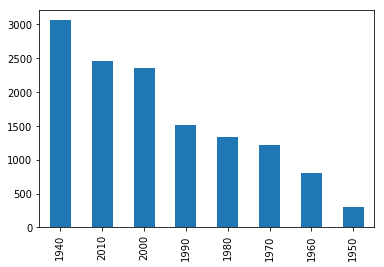

In [51]:
pd.Series(df.decade.sum()).value_counts().plot(kind="bar")

Wow, lots of 1940's....seems a bit off. After a quick check on the ultimate guitar website I realized that there are no 1940's chords at all. So there was a bug in my web scraper that was adding in that date as a filter. I should have only been going back to 1950. 

This might explain why there are multiple decades for some songs. A song can only be from one decade. Lets see if all of these multi-decade songs have a 1940 in them.

In [52]:
a=df[df['decade'].map(len)>1]
print('Entries with multiple decade values: ', a.size)
mask = a.decade.apply(lambda x: 1940 in x)
print('Multiple decade values that contain 1940: ', a[mask].size)
newCol=a['decade'].map(len)
print('Maximum length of duplicate values: ', max(newCol))

Entries with multiple decade values:  36528
Multiple decade values that contain 1940:  36528
Maximum length of duplicate values:  2


Awesome news...all of these entries that have multiple decade values have 2 decades in their list, and one of those decades is a 1940. Also, when I check out those filters on ultimate guitar, it seems all of the rest of the info is correct...so all I need to do is remove the "1940" decade tag from them and the rest of the data is still good values. We shouldn't have any more duplicate decades after that.

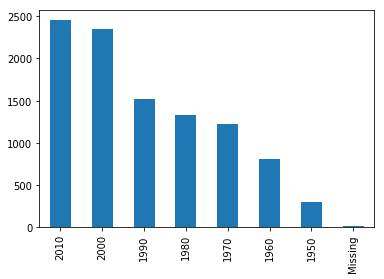

In [53]:
# remove 1940s from data. found during initial data analysis that these values were brought in incorrectly...no 1940 data online. when scraping for 1940 it just removes that filter but keeps the other (genre)
def removeFourtys(decades):
    newList=[]
    for dec in decades:
        if dec!=1940:
            newList.append(dec)
    if len(newList)>0:
        return str(max(newList))
    else:
        return np.NaN

df['decade']=df.decade.apply(removeFourtys)
df.fillna('Missing').decade.value_counts().plot(kind='bar')


Much better...After removing 1940 as a possible decade, we see that most of our tabs are from recent decades. The amount of tabs decreases as we go further back in time. There are a couple of tabs now missing decades since all they had were "1940". We can either clean those up by hand or just remove them...

(PS I've also gone ahead and fixed that bug in my scraper in case any one else wants to use it!) 

In [54]:
# df[df['decade'].isnull()]

### Genres

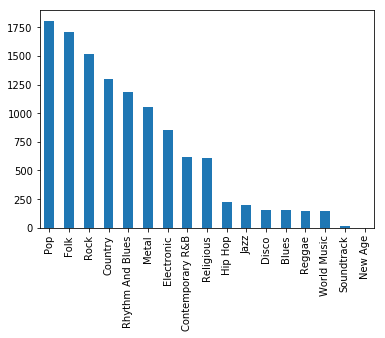

In [55]:
pd.Series(df.genre.sum()).value_counts().plot(kind="bar")

Similar to decades, a song potentially has multiple genres. However, unlike decades, having multiple genres is definitely possible. 

Entries with multiple genre values:  18636


Text(0, 0.5, 'Count')

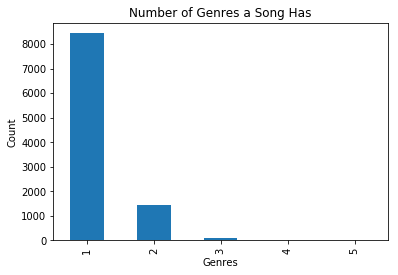

In [56]:
a=df[df['genre'].map(len)>1]
print('Entries with multiple genre values: ', a.size)
# newCol=a['genre'].map(len)
# print('Maximum length of duplicate values: ', max(newCol))
ax =df['genre'].map(len).value_counts().plot(kind='bar', title='Number of Genres a Song Has')
ax.set_xlabel("Genres")
ax.set_ylabel("Count")

So most songs only have one genre, but we still have quite a few with multiple (some even have 5). I actually don't think we want to remove the multiple tags from the genres. It could be interesting to explore songs that cross genres, how they are related, etc...so we'll leave these as are in list format.

Another thing I'm interested to see is how our decades and genres are related. I would assume that most of our Pop songs are from 2000's on, and Jazz would be earlier on. Lets try to graph this breakdown. It will be a good excercise in playing with pandas group by's as well

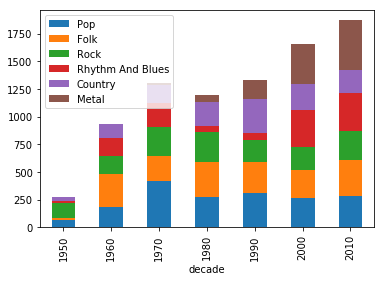

In [57]:
groups=df.groupby('decade')['genre'].apply(lambda x: list(x)).apply(lambda x: [item for sublist in x for item in sublist]).apply(lambda x: pd.Series(x).value_counts())
# pd.Series(groups[1950]).value_counts().transpose().plot(kind="bar")

groups[['Pop','Folk','Rock','Rhythm And Blues','Country','Metal']].plot(kind='bar', stacked=True)
# groups.Pop.plot(kind='bar', title='pop')

# df.genre.value_counts().sort_values()

Nevermind! There actually is a fairly even split among all decades. This is honestly unexpected. This means that when I filtered on UG by "2010+Pop", I recieved a similar amount of data for the filter "1980+Pop". This is great that we have a balanced data set though! That was one of the reasons of scraping in the way I did.

In [58]:
# (df[df['decade']=='1970'])[df.genre.apply(lambda x: 'Pop' in x)]

### Songs and Artists

Lets take a look at our artists first. I wonder how many diferent artists we have in this dataset?

In [59]:
print("Unique artists in data set: ", df.artist.nunique())

Unique artists in data set:  872


Interesting, so we only have 872 unique artist, but we have over 7000 tabs. That means we have multiple songs per artist. Lets see which artists have the most songs in our dataset

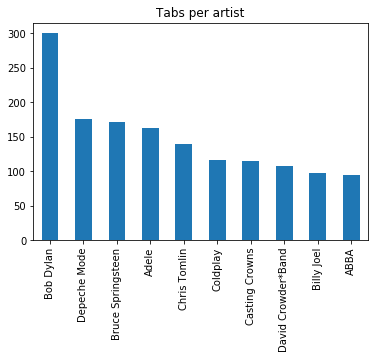

In [60]:
df.artist.value_counts().head(10).plot(kind='bar', title='Tabs per artist')

In [61]:
# df.artist.value_counts().plot(kind='hist', bins=25,title='Tabs per artist', edgecolor='k')
# ax = sns.distplot(df.artist.value_counts(),bins=25 ,hist=True, color='b',hist_kws=dict(edgecolor="k", linewidth=2))
# plt.title('Distribution of Tab Count Per Artist') 
# plt.ylabel('Frequency')
# plt.xlabel('Tab Count')

Lets look at the top artist from this group, Bob Dylan, to get an idea of what a breakdown of all his songs are

number of bob dylan songs with tabs:  152
number of bob dylan songs with multiple versions:  80


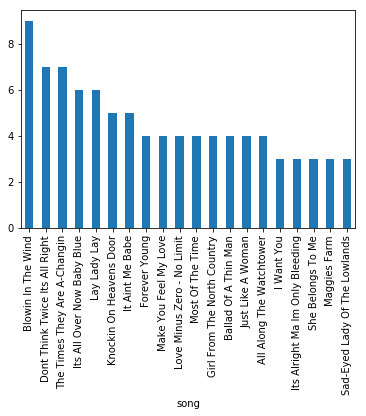

In [62]:
dylan=df[df['artist']=="Bob Dylan"]
dylanSongs=dylan.groupby('song').size().sort_values(ascending=False)
print("number of bob dylan songs with tabs: ", len(dylanSongs))
print("number of bob dylan songs with multiple versions: ",len(dylanSongs[dylanSongs>1]) )
dylanSongs.head(20).plot(kind='bar')

lets look specifically into Blowing in the Wind to see what the differences are

In [63]:
dylan[dylan['song']=='Blowin In The Wind']

,url,chordOrder,uniqueChords,song,artist,genre,decade,difficulty,tuning,capo,key,other
4996,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[D, D, G, D, G, D, D, G, D, G, A, D, G, D, G, ...","[D, G, A, Bm]",Blowin In The Wind,Bob Dylan,"[Folk, Rock]",1960,novice,NaN,NaN,D,NaN
4997,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[C, F, C, Am, C, F, G, G7, C, F, C, Am, C, F, ...","[C, F, Am, G, G7, E7]",Blowin In The Wind,Bob Dylan,"[Folk, Rock]",1960,NaN,E A D G B E,NaN,NaN,NaN
4998,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[G, C, D, G, C, G, G, C, D, G, C, D, G, C, D, ...","[G, C, D]",Blowin In The Wind,Bob Dylan,"[Folk, Rock]",1960,novice,E A D G B E,7th fret,D,NaN
4999,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[C, D, G, C, D, G, G, C, D, G, C, D, G, C, D, ...","[C, D, G]",Blowin In The Wind,Bob Dylan,"[Folk, Rock]",1960,NaN,NaN,NaN,NaN,NaN
5000,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[G, C, G, C, G, G, C, G, C, D, G, C, G, C, G, ...","[G, C, D, Em]",Blowin In The Wind,Bob Dylan,"[Folk, Rock]",1960,novice,E A D G B E,6th fret,NaN,NaN
5001,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[G, G, C, G/B, D/A, G, G, C, G/B, G, G, C, G/B...","[G, C, G/B, D/A, C/B, D/F#, C/G, D]",Blowin In The Wind,Bob Dylan,[Folk],1960,intermediate,E A D G B E,7th fret,D,"Chords for the classic acoustic version from ""..."
5002,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[D, D, G, A, D, G, D, G, A, D, G, A, D, G, A, ...","[D, G, A, Bm]",Blowin In The Wind,Bob Dylan,[Folk],1960,NaN,E A D G B E,NaN,NaN,NaN
5003,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[G, C, G, C, G, G, C, G, C, D, G, C, G, C, G, ...","[G, C, D]",Blowin In The Wind,Bob Dylan,[Folk],1960,NaN,E A D G B E,NaN,NaN,NaN
5004,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[C, F, C, C, C, F, C, C, C, F, C, C, C, F, C, ...","[C, F, G, Am]",Blowin In The Wind,Bob Dylan,[Folk],1960,novice,E A D G B E,2nd fret,NaN,NaN


Interesting, so looks like there are 9 pretty different versions of the same song. There are a few basic versions where the songs only use C D and G. Theres another version with D G A and Bm. Theres also an intermediate version with some more unique chords...

Lets look at these multi-versioned songs on a higher level.

In [64]:
songArtist=df.groupby(['song','artist']).size().sort_values(ascending=False)
print("Number of unique songs in db: ", len(songArtist))
print("Number of songs that have multiple versions: ", songArtist[songArtist>1].sum())

Number of unique songs in db:  6365
Number of songs that have multiple versions:  5564


Interesting, so a majority of our songs all have multiple versions in this data set. It could be interesting to look at differences across versions at some point!

As a first step though, lets look at which songs have the most versions in this data set.

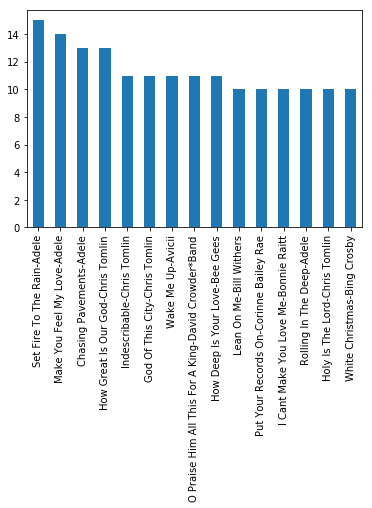

In [65]:
(df['song']+'-'+df['artist']).value_counts().head(15).plot(kind='bar')
# df.song.value_counts().head(10).plot(kind='bar')

Adele really dominates this list, tons of songs with multiple versions.

### Song Difficulties, Tuning, Capo, and Key (Not Finished)

On to the next. These values were all gathered in one field listed at the top of the tab.

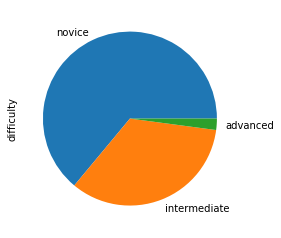

In [66]:
df.difficulty.value_counts().plot(kind='pie')

Whats the most difficult genre to play?

#### Deal with Missing Values

- Steal values from other tabs of the same song (genre, decade, etc.) 
- Take data from other column
- Make assumptions about tuning and capo
- Calculate key from chords in song

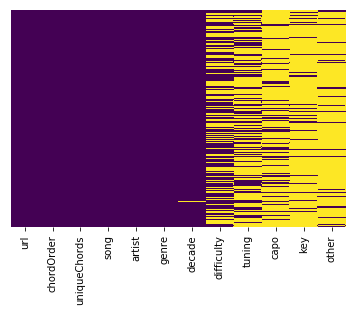

In [67]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [68]:
# use other column to add tunings where missing

df['other']= df.other.apply(lambda x: x.lower() if isinstance(x, str) else x)
df.loc[df['other'].str.contains("standard tuning") & df['tuning'].isnull(),
      'tuning']='E A D G B E'

# Chord Analysis (Not Finished)

I honestly don't even know where to start with these. I think the best way forward will be to just ask some questions, and try to find answers. That might inform next questions and steps for modeling as well. I'm going to list out some question ideas below.

#### Questions to answer

* What are the most used chords?

* How many chords do most songs have?

* What are the total number of unique chords in all the songs

* What is the most likely chord to happen after another chord?(i.e what transition should you learn)

* How do chords and transitions differ by genre? (how do chords define genres)

* What chords do you need to know for each difficulty level?

* top chords per genre, decade, artist?
* predict the genre or decade based on chords, cardinality, etc?


#### Potential cleaning of chords remaining

* Changing chord names based on capo??
https://www.youtube.com/watch?v=Ky8uOOfI2tY

* Adding key based on chords in song

* Getting numeric notation chord sequence



#### What are the most used chords across all songs?

In [69]:
chordList=df.uniqueChords.sum()

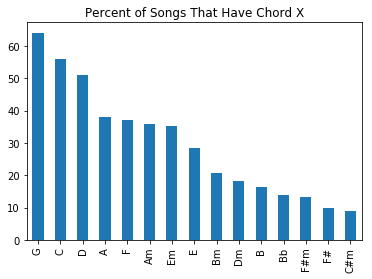

In [70]:
# pd.Series(chordList).value_counts().sort_values(ascending=False).head(15).plot(kind='bar')
((pd.Series(chordList).value_counts().sort_values(ascending=False)/len(df))* 100).head(15).plot(kind='bar', title='Percent of Songs That Have Chord X')

Wow G C and D are all in over 50% of the songs in the DB!

#### How many unique chords are in this database?

In [71]:
uniqueChords=len(list(set(chordList)))
print("There are {} unique chords used across all songs".format(uniqueChords))

There are 1730 unique chords used across all songs


Is this right?? Are there that many unique chords...

In [72]:
chordCounts=pd.Series(chordList).value_counts().sort_values(ascending=False)
chordCounts[chordCounts==1]

G2/B         1
G7(b9)       1
B7(sus)      1
A#+          1
Am#6         1
D6/B         1
Dbadd9/F     1
D7#5         1
A7sus4/G     1
Eb+5         1
Gm/A#        1
D#13b9       1
A9/B         1
Gm6/F        1
Aadd4/D      1
C#7/Ab       1
A7-9/C#      1
G#m/C#       1
Bm13         1
F#/B         1
Cm7add4      1
G#/G         1
DbM          1
Dmi          1
Gm7add4      1
Abadd9       1
Amaj7sus2    1
F7/C         1
Eb6/D        1
G5/E         1
            ..
D-9/E        1
Bbm7-5       1
F#7/D        1
Dadd2/E      1
C#-5         1
Ammaj7/G#    1
Bb7-5        1
E7(sus)      1
DbmM7        1
Bb7(b13)     1
Am6/F#       1
Gm6/9        1
E5/D#        1
Bbmaj7/D     1
D5/F#        1
Bb7M         1
D7sus4/A     1
G6sus2       1
E13b9        1
Csus2/Eb     1
Dbmaj9       1
Dmin6/D      1
G#/A#        1
F#/Ab        1
G+5          1
C6/A         1
B(sus4)      1
E#dim7       1
Gdim/Eb      1
C#7(sus)     1
Length: 776, dtype: int64

Maybe we can check by seeing if chords are used across multiple songs? I would assume if they are only used once in the entire DB of 10k songs, it's likely they are just written in a unique way

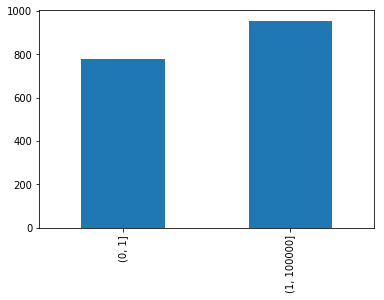

In [73]:
ranges = [0,1,2,3,4,5,6,7,8,9,10,50, 100, 100000]
ranges = [0,1,100000]
chordCounts.groupby(pd.cut(chordCounts, ranges)).count().plot(kind='bar')
# df.groupby(pd.cut(df.a, ranges)).count()

https://www.uberchord.com/blog/learn-how-to-read-guitar-chord-chart-symbols/

So theres a ton of chords...unclear if these are all legit or not

### How many chords do most songs have?


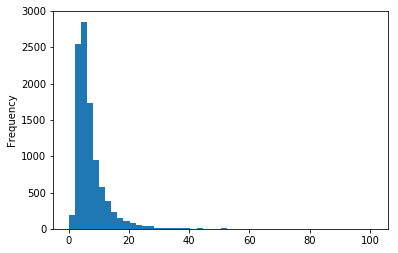

In [74]:
df['cardinality']=df.uniqueChords.apply(lambda x: len(x))
df.cardinality.plot(kind='hist', bins=50)

In [75]:
print('Song Chord Info')
print('Median Cardinality: ', df['cardinality'].median())
print('Max Cardinality: ', df['cardinality'].max())
print('Min Cardinality: ', df['cardinality'].min())

Song Chord Info
Median Cardinality:  6.0
Max Cardinality:  101
Min Cardinality:  0


Lets look into these ones with weird cardinalities....

### Do songs often use the same chords?

In [76]:
# dfNov=df[df['difficulty']=='novice']
# dfInt=df[df['difficulty']=='intermediate']
# dfAdv=df[df['difficulty']=='advanced']
# novChords=pd.Series(dfNov.uniqueChords.sum())

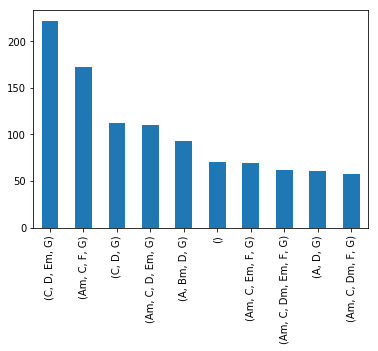

In [77]:
# novChords.value_counts()
df.uniqueChords.apply(sorted).apply(tuple).value_counts().head(10).plot(kind='bar')

In [78]:
df['uniqueChordsTup']=df.uniqueChords.apply(sorted).apply(tuple)

In [79]:
df[df['uniqueChords'].apply(sorted).apply(tuple)==('C','D','Em','G')].difficulty.value_counts()

novice          127
intermediate     18
advanced          1
Name: difficulty, dtype: int64

This makes a lot of sense....

https://www.youtube.com/watch?v=2pXS8k1zx8U

In [80]:
df.head()

,url,chordOrder,uniqueChords,song,artist,genre,decade,difficulty,tuning,capo,key,other,cardinality,uniqueChordsTup
0,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[G, C, G, C, D, G, C, G, C, D, G, C, G, C, D, ...","[G, C, D]",Its All Wrong But Its All Right,Dolly Parton,[Country],1970,NaN,NaN,NaN,NaN,NaN,3,"(C, D, G)"
1,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Am, C, G, Am, G, Am, Am, C, G, Am, G, Am, Am,...","[Am, C, G]",Jolene,Dolly Parton,"[Country, Folk]",1970,intermediate,E A D G B E,4th fret,NaN,NaN,3,"(Am, C, G)"
2,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Em, G, D, Em, D, Em, Em, G, D, Em, Em, G, D, ...","[Em, G, D]",Jolene,Dolly Parton,[Country],1970,novice,E A D G B E,4th fret,NaN,NaN,3,"(D, Em, G)"
3,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Dm, F, C, Dm, C, Dm, F, C, Dm, C, Dm, Dm, F, ...","[Dm, F, C]",Jolene,Dolly Parton,"[Country, Folk]",1970,NaN,NaN,NaN,NaN,NaN,3,"(C, Dm, F)"
4,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Am, Am, C, G, Am, G, Am, Am, C, G, Am, G, Em,...","[Am, C, G, Em]",Jolene,Dolly Parton,"[Country, Folk]",1970,novice,E A D G B E,4th fret,C#m,NaN,4,"(Am, C, Em, G)"


In [81]:
chordGroups=df.uniqueChordsTup.value_counts().head(20)
dfTest=df[df['uniqueChordsTup'].isin(chordGroups.index.to_list())]

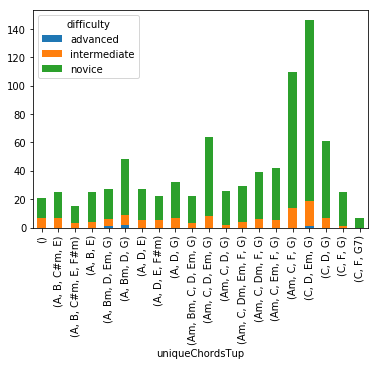

In [82]:
dfTest.groupby(['uniqueChordsTup', 'difficulty']).size().unstack(fill_value=0).plot(kind='bar', stacked=True)

Two things...
1) would be nice for this graph to be sorted
2) why is a song difficult with an easy chord progression

In [83]:
dfTest.groupby(['uniqueChordsTup', 'difficulty']).size().unstack(fill_value=0)

difficulty,advanced,intermediate,novice
uniqueChordsTup,,,
(),0,7,14
"(A, B, C#m, E)",0,7,18
"(A, B, C#m, E, F#m)",0,3,12
"(A, B, E)",0,4,21
"(A, Bm, D, Em, G)",1,5,21
"(A, Bm, D, G)",2,7,39
"(A, D, E)",0,5,22
"(A, D, E, F#m)",0,5,17
"(A, D, G)",0,7,25


In [84]:
df[df['uniqueChordsTup']==('C','D','Em','G')]

,url,chordOrder,uniqueChords,song,artist,genre,decade,difficulty,tuning,capo,key,other,cardinality,uniqueChordsTup
53,https://tabs.ultimate-guitar.com/tab/don-henle...,"[Em, C, D, G, Em, Em, C, D, C, G, D, C, G, D, ...","[Em, C, D, G]",The Boys Of Summer,Don Henley,[Rock],1980,novice,NaN,1st fret,NaN,NaN,4,"(C, D, Em, G)"
105,https://tabs.ultimate-guitar.com/tab/don-willi...,"[G, C, G, G, C, D, G, G, Em, C, D, G, C, G, G,...","[G, C, D, Em]",Falling In Love,Don Williams,[Country],1970,novice,NaN,NaN,NaN,NaN,4,"(C, D, Em, G)"
245,https://tabs.ultimate-guitar.com/tab/dougie-ma...,"[Em, Em, D, Em, Em, D, Em, D, Em, C, D, Em, D,...","[Em, D, C, G]",Are Ye Sleepin Maggie,Dougie MacLean,[Folk],1980,novice,E A D G B E,1st fret,Em,less complicated key. includes chords througho...,4,"(C, D, Em, G)"
250,https://tabs.ultimate-guitar.com/tab/dougie-ma...,"[G, D, Em, C, G, D, Em, C, G, D, Em, C, G, D, ...","[G, D, Em, C]",Caledonia,Dougie MacLean,[Folk],1980,novice,NaN,3rd fret,NaN,NaN,4,"(C, D, Em, G)"
324,https://tabs.ultimate-guitar.com/tab/drake/cre...,"[C, D, Em, G]","[C, D, Em, G]",Crew Love,Drake feat. The Weeknd,"[Hip Hop, Contemporary R&B]",2010,novice,NaN,5th fret,NaN,NaN,4,"(C, D, Em, G)"
356,https://tabs.ultimate-guitar.com/tab/drake/sho...,"[C, D, G, Em, C, D, G, Em, C, D, G, Em, C, D, ...","[C, D, G, Em]",Shot For Me,Drake,"[Hip Hop, Contemporary R&B]",2010,novice,NaN,NaN,NaN,NaN,4,"(C, D, Em, G)"
359,https://tabs.ultimate-guitar.com/tab/drake/tak...,"[Em, C, G, D]","[Em, C, G, D]",Take Care,Drake feat. Rihanna,"[Hip Hop, Contemporary R&B]",2010,novice,NaN,NaN,NaN,NaN,4,"(C, D, Em, G)"
600,https://tabs.ultimate-guitar.com/tab/dwight-yo...,"[C, C, C, G, G, G, G, Em, D, C, G, Em, D, G, C...","[C, G, Em, D]",Purple Rain,Dwight Yoakam,[Country],2010,novice,NaN,3rd fret,NaN,NaN,4,"(C, D, Em, G)"
695,https://tabs.ultimate-guitar.com/tab/ed-sheera...,"[G, C, Em, D, G, C, Em, D, G, C, Em, D, G, C, ...","[G, C, Em, D]",Castle On The Hill,Ed Sheeran,[Folk],2010,novice,NaN,7th fret,G,this version is simple and works well of you h...,4,"(C, D, Em, G)"
702,https://tabs.ultimate-guitar.com/tab/ed-sheera...,"[G, G, G, D, Em, Em, D, C, C, D, G, G, G, G, D...","[G, D, Em, C]",Drunk,Ed Sheeran,[Folk],2010,NaN,E A D G B E,NaN,NaN,NaN,4,"(C, D, Em, G)"


Can we do this same thing for genres?

In [85]:
# df['genreTup']=df.genre.apply(sorted).apply(tuple)
# dfTest=df[df['uniqueChordsTup'].isin(chordGroups.index.to_list())]
# dfTest.groupby(['uniqueChordsTup', 'genreTup']).size().unstack(fill_value=0).plot(kind='bar', stacked=True)

In [86]:
dfTest=df[df['uniqueChordsTup'].isin(chordGroups.index.to_list())]
# dfTest.groupby(['uniqueChordsTup', 'genreTup']).size().unstack(fill_value=0).plot(kind='bar', stacked=True)

#### How many songs do you know by learning x top chords?

In [87]:
set('G','C')==('C','G')

TypeError: set expected at most 1 arguments, got 2